In [21]:
pip install -U ipykernel

Note: you may need to restart the kernel to use updated packages.


In [22]:
!pip install inference[sam]

!pip install inference[clip]

!pip install inference[gaze]

!pip install inference[grounding-dino]

!pip install inference[yolo-world]

!pip install inference[transformers]

## Import Libraries

In [23]:
import cv2
import numpy as np
from PIL import Image
import supervision as sv
from inference import get_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [35]:
class WarehouseItemDetector:
    """
    A module for detecting items (bags, sacks, boxes) in warehouse images
    """
    
    def __init__(self, model_id="yolov8s-640", confidence_threshold=0.1):
        """
        Initialize the detector
        
        Args:
            model_id (str): YOLOv8 model identifier
            confidence_threshold (float): Minimum confidence for detections
        """
        self.model_id = model_id
        self.confidence_threshold = confidence_threshold
        self.model = None
        self.load_model()
    
    def load_model(self):
        """Load the YOLO model"""
        try:
            self.model = get_model(model_id=self.model_id)
            print(f"✅ Model {self.model_id} loaded successfully")
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            raise
    
    def load_image(self, image_path):
        """
        Load image from file path
        
        Args:
            image_path (str): Path to the image file
            
        Returns:
            tuple: (opencv_image, rgb_array)
        """
        try:
            # Load with OpenCV (BGR format)
            opencv_image = cv2.imread(image_path)
            if opencv_image is None:
                raise ValueError(f"Could not load image from {image_path}")
            
            # Load with PIL and convert to RGB numpy array
            pil_image = Image.open(image_path)
            rgb_array = np.array(pil_image.convert('RGB'))
            
            print(f"✅ Image loaded - Shape: {rgb_array.shape}, Type: {rgb_array.dtype}")
            return opencv_image, rgb_array
            
        except Exception as e:
            print(f"❌ Error loading image: {e}")
            raise
    
    def detect_items(self, image_rgb):
        """
        Detect items in the image
        
        Args:
            image_rgb (np.ndarray): RGB image array
            
        Returns:
            sv.Detections: Detection results
        """
        try:
            # Run inference
            results = self.model.infer(image_rgb)[0]
            detections = sv.Detections.from_inference(results)
            
            # Filter by confidence threshold
            detections = detections[detections.confidence > self.confidence_threshold]
            
            print(f"✅ Found {len(detections)} objects with confidence > {self.confidence_threshold}")
            
            return detections
            
        except Exception as e:
            print(f"❌ Error during detection: {e}")
            raise
    
    def annotate_image(self, image_bgr, detections, show_labels=True):
        """
        Annotate image with detection results
        
        Args:
            image_bgr (np.ndarray): BGR image array
            detections (sv.Detections): Detection results
            show_labels (bool): Whether to show labels
            
        Returns:
            np.ndarray: Annotated image
        """
        annotated_image = image_bgr.copy()
        
        # Draw bounding boxes
        box_annotator = sv.BoxAnnotator(
            thickness=4,
            color_lookup=sv.ColorLookup.INDEX
        )
        annotated_image = box_annotator.annotate(annotated_image, detections)
        
        # Add labels if requested
        if show_labels:
            label_annotator = sv.LabelAnnotator(
                text_scale=1.0,
                text_thickness=2,
                color_lookup=sv.ColorLookup.INDEX
            )
            
            # Create labels with class names and confidence scores
            labels = []
            for i in range(len(detections)):
                class_id = detections.class_id[i] if detections.class_id is not None else 0
                confidence = detections.confidence[i] if detections.confidence is not None else 0
                # You might want to map class_id to actual class names
                label = f"Item {class_id}: {confidence:.2f}"
                labels.append(label)
            
            annotated_image = label_annotator.annotate(annotated_image, detections, labels)
        
        return annotated_image
    
    def display_results(self, annotated_image):
        """Display the annotated image"""
        # Convert BGR to RGB for matplotlib
        rgb_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(15, 10))
        plt.imshow(rgb_image)
        plt.axis('off')
        plt.title('Detected Items in Warehouse', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def print_detection_summary(self, detections):
        """Print summary of detections"""
        print("\n" + "="*50)
        print("DETECTION SUMMARY")
        print("="*50)
        print(f"Total items detected: {len(detections)}")
        
        if len(detections) > 0:
            print(f"Confidence range: {detections.confidence.min():.3f} - {detections.confidence.max():.3f}")
            
            # Group by class if available
            if detections.class_id is not None:
                unique_classes, counts = np.unique(detections.class_id, return_counts=True)
                print("Items by class:")
                for class_id, count in zip(unique_classes, counts):
                    print(f"  Class {class_id}: {count} items")
        print("="*50)
    
    def get_item_boundaries(self, detections):
        """
        Extract bounding box coordinates for each detected item
        
        Args:
            detections (sv.Detections): Detection results
            
        Returns:
            list: List of dictionaries containing boundary information
        """
        boundaries = []
        
        for i in range(len(detections)):
            bbox = detections.xyxy[i]  # [x1, y1, x2, y2]
            
            boundary_info = {
                'item_id': i,
                'x1': int(bbox[0]),
                'y1': int(bbox[1]), 
                'x2': int(bbox[2]),
                'y2': int(bbox[3]),
                'width': int(bbox[2] - bbox[0]),
                'height': int(bbox[3] - bbox[1]),
                'center_x': int((bbox[0] + bbox[2]) / 2),
                'center_y': int((bbox[1] + bbox[3]) / 2),
                'confidence': float(detections.confidence[i]) if detections.confidence is not None else 0.0,
                'class_id': int(detections.class_id[i]) if detections.class_id is not None else 0
            }
            
            boundaries.append(boundary_info)
        
        return boundaries

print("✅ WarehouseItemDetector class defined successfully")

✅ WarehouseItemDetector class defined successfully


In [36]:
# Initialize detector with your preferred settings
detector = WarehouseItemDetector(
    model_id="yolov8s-640",
    confidence_threshold=0.1  # Adjust this value based on your needs
)

print("✅ Detector initialized and ready to use!")

✅ Model yolov8s-640 loaded successfully
✅ Detector initialized and ready to use!


✅ Image loaded - Shape: (960, 1280, 3), Type: uint8


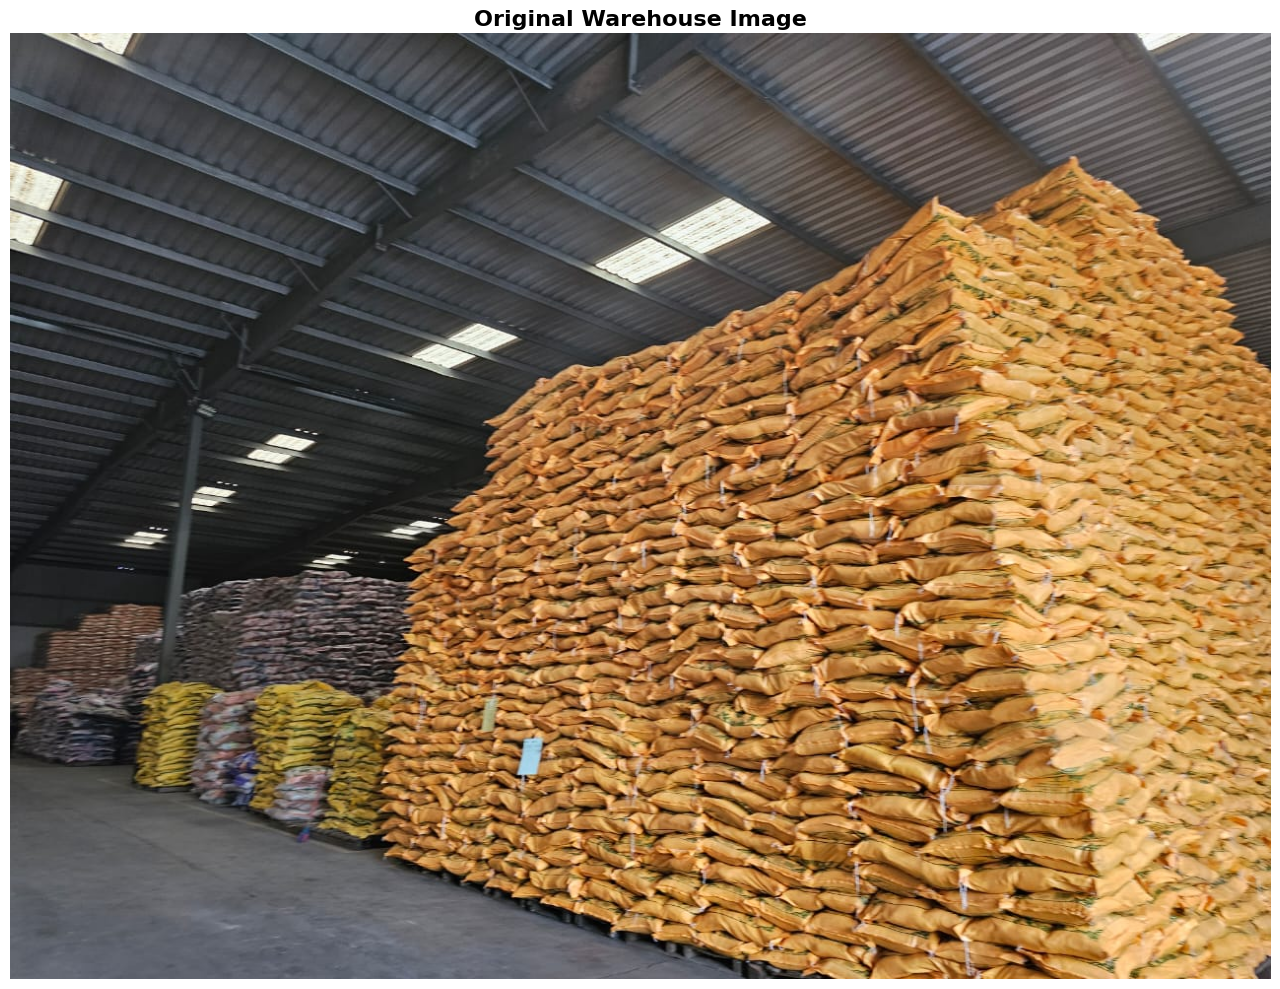

In [37]:
# Update this path to your image location
image_path = "./WhatsApp Image 2025-09-09 at 12.58.41 PM.jpeg"

try:
    # Load the image
    image_bgr, image_rgb = detector.load_image(image_path)
    
    # Display original image
    plt.figure(figsize=(15, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Original Warehouse Image', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error loading image: {e}")
    print("Please make sure the image path is correct and the file exists.")


In [38]:
try:
    # Detect items in the image
    detections = detector.detect_items(image_rgb)
    
    # Print detection summary
    detector.print_detection_summary(detections)
    
except Exception as e:
    print(f"❌ Error during detection: {e}")

✅ Found 0 objects with confidence > 0.1

DETECTION SUMMARY
Total items detected: 0


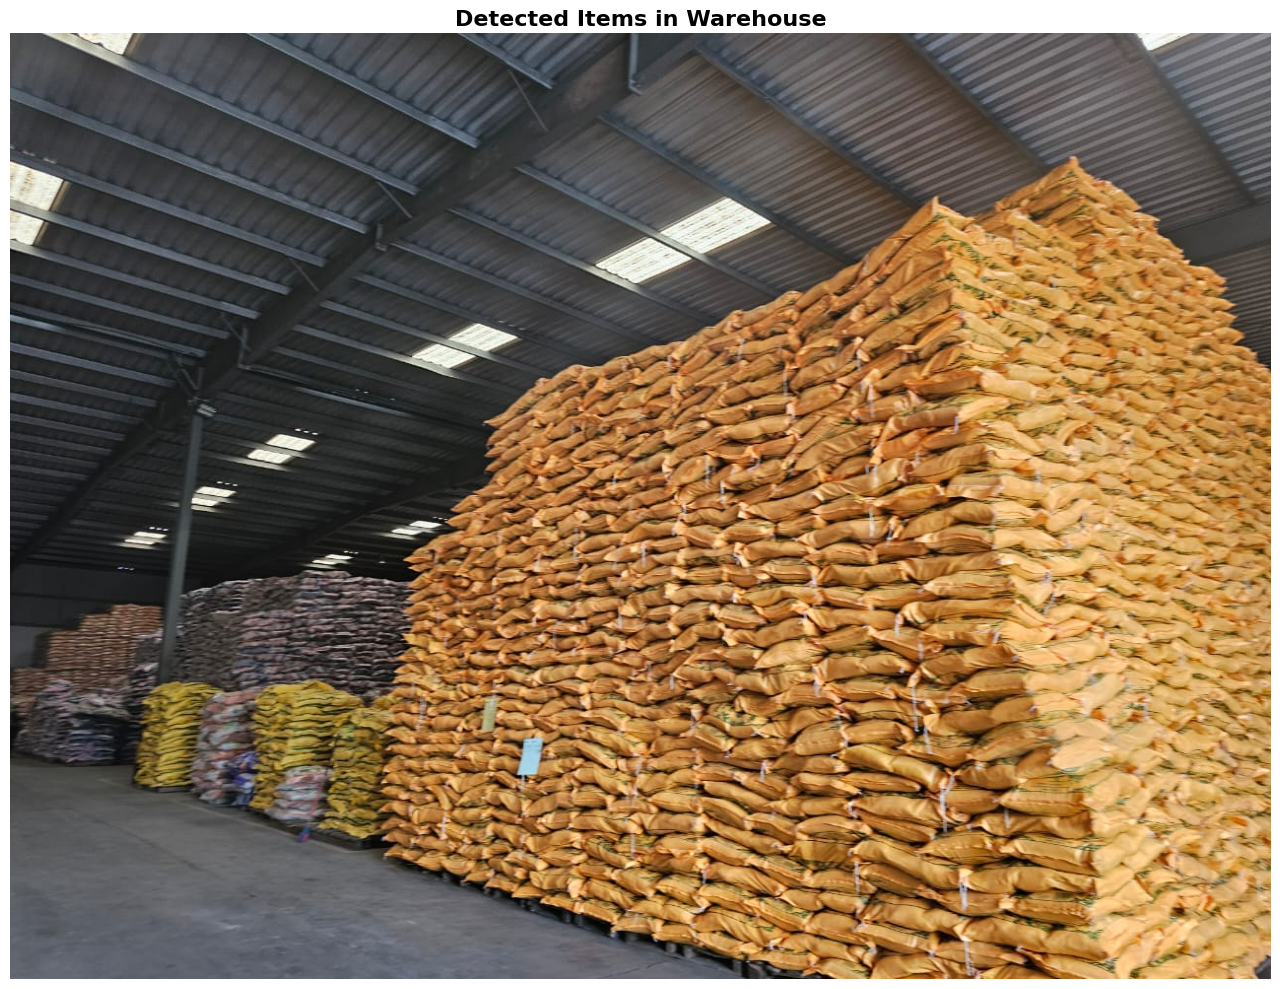

✅ Annotated image saved as 'detected_items_output.jpg'


In [39]:
try:
    # Annotate the image with detection results
    annotated_image = detector.annotate_image(image_bgr, detections, show_labels=True)
    
    # Display the annotated image
    detector.display_results(annotated_image)
    
    # Save the annotated image
    cv2.imwrite("./detected_items_output.jpg", annotated_image)
    print("✅ Annotated image saved as 'detected_items_output.jpg'")
    
except Exception as e:
    print(f"❌ Error during visualization: {e}")

In [29]:
try:
    # Get detailed boundary information for each detected item
    boundaries = detector.get_item_boundaries(detections)
    
    print("\n" + "="*70)
    print("DETAILED BOUNDARY INFORMATION")
    print("="*70)
    
    for boundary in boundaries:
        print(f"Item {boundary['item_id']:2d}: "
              f"Box({boundary['x1']:4d}, {boundary['y1']:4d}, {boundary['x2']:4d}, {boundary['y2']:4d}) "
              f"| Size: {boundary['width']:4d}x{boundary['height']:4d} "
              f"| Center: ({boundary['center_x']:4d}, {boundary['center_y']:4d}) "
              f"| Confidence: {boundary['confidence']:.3f} "
              f"| Class: {boundary['class_id']}")
    
    print("="*70)
    
except Exception as e:
    print(f"❌ Error extracting boundaries: {e}")


DETAILED BOUNDARY INFORMATION


In [40]:
try:
    if len(boundaries) > 0:
        # Calculate some statistics
        areas = [b['width'] * b['height'] for b in boundaries]
        confidences = [b['confidence'] for b in boundaries]
        
        print("\n" + "="*50)
        print("ADVANCED STATISTICS")
        print("="*50)
        print(f"Average item area: {np.mean(areas):.0f} pixels²")
        print(f"Largest item area: {np.max(areas):.0f} pixels²")
        print(f"Smallest item area: {np.min(areas):.0f} pixels²")
        print(f"Average confidence: {np.mean(confidences):.3f}")
        print(f"Standard deviation of confidence: {np.std(confidences):.3f}")
        print("="*50)
        
        # Create a simple visualization of item sizes
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(areas, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('Item Area (pixels²)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Item Areas')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist(confidences, bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.xlabel('Confidence Score')
        plt.ylabel('Frequency')
        plt.title('Distribution of Confidence Scores')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"❌ Error in advanced analysis: {e}")

In [31]:
try:
    # Create a summary report
    import pandas as pd
    
    # Convert boundaries to DataFrame for easy viewing and export
    df = pd.DataFrame(boundaries)
    
    print("\n" + "="*50)
    print("DETECTION RESULTS DATAFRAME")
    print("="*50)
    print(df.to_string(index=False))
    
    # Save to CSV
    df.to_csv('./warehouse_detections.csv', index=False)
    print("\n✅ Results exported to 'warehouse_detections.csv'")
    
except Exception as e:
    print(f"❌ Error exporting results: {e}")


DETECTION RESULTS DATAFRAME
Empty DataFrame
Columns: []
Index: []

✅ Results exported to 'warehouse_detections.csv'


In [41]:
def test_different_thresholds():
    """Test different confidence thresholds to find the optimal setting"""
    
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    results_summary = []
    
    print("Testing different confidence thresholds...")
    print("-" * 50)
    
    for threshold in thresholds:
        # Create detector with new threshold
        test_detector = WarehouseItemDetector(
            model_id="yolov8n-640",
            confidence_threshold=threshold
        )
        
        # Run detection
        test_detections = test_detector.detect_items(image_rgb)
        
        # Store results
        results_summary.append({
            'threshold': threshold,
            'num_detections': len(test_detections),
            'avg_confidence': np.mean(test_detections.confidence) if len(test_detections) > 0 else 0
        })
        
        print(f"Threshold {threshold:.1f}: {len(test_detections)} items detected")
    
    return results_summary

# Uncomment the line below to test different thresholds
# threshold_results = test_different_thresholds()

print("\n🎉 Warehouse Item Detection Module is ready!")
print("📝 Instructions:")
print("1. Run each cell in sequence")
print("2. Update the image_path in Cell 5 to your image location")
print("3. Adjust confidence_threshold in Cell 4 if needed")
print("4. Use Cell 11 to find optimal detection parameters")
print("5. All results will be displayed inline and saved to files")



🎉 Warehouse Item Detection Module is ready!
📝 Instructions:
1. Run each cell in sequence
2. Update the image_path in Cell 5 to your image location
3. Adjust confidence_threshold in Cell 4 if needed
4. Use Cell 11 to find optimal detection parameters
5. All results will be displayed inline and saved to files


Number of detections: 0
❌ No detections found. Let's re-run the detection...
✅ Found 0 objects with confidence > 0.2
With lower threshold - Number of detections: 0
❌ No items detected!
Let's try with an even lower confidence threshold...
✅ Found 0 objects with confidence > 0.1
❌ Still no detections. The image might not contain recognizable objects.
Let's display the original image to verify it loaded correctly:


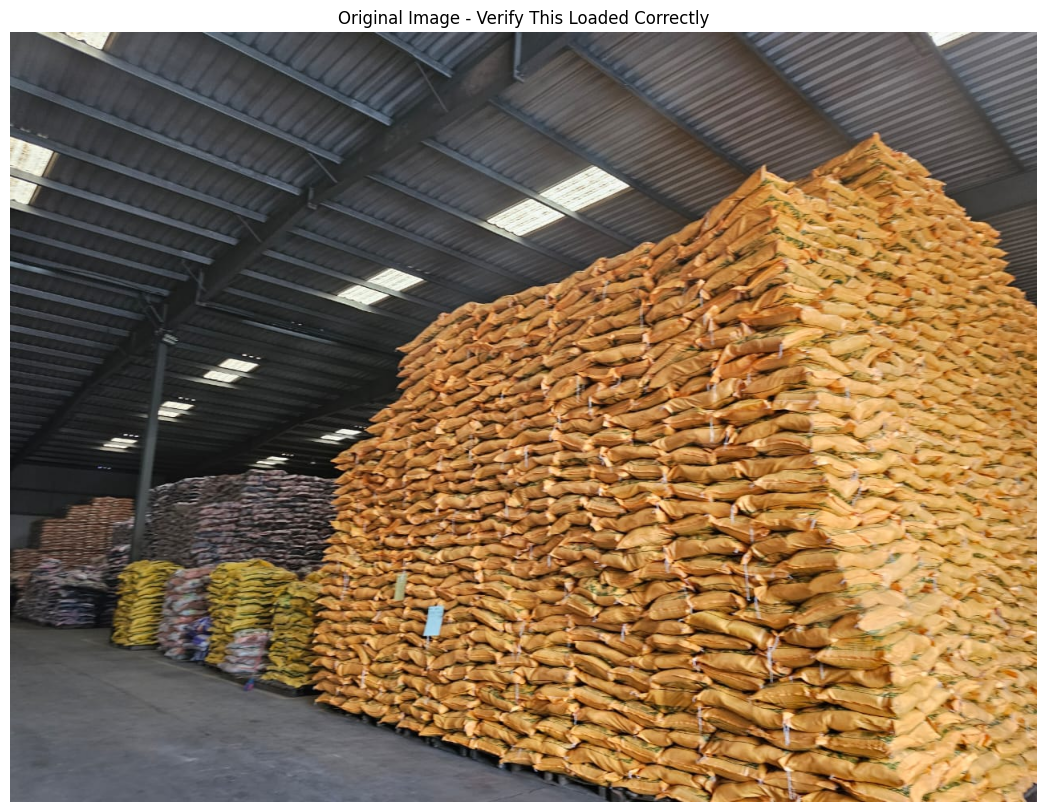

If you can see your warehouse image above, try:
1. Using a different YOLO model (yolov8s-640 or yolov8m-640)
2. Checking if the image contains standard objects YOLO can detect
3. The bags might need a custom trained model for better detection


In [42]:
# First, let's check if we have detections
try:
    print(f"Number of detections: {len(detections)}")
    print(f"Detection confidence range: {detections.confidence.min():.3f} - {detections.confidence.max():.3f}")
except:
    print("❌ No detections found. Let's re-run the detection...")
    # Re-run detection with lower threshold
    detector.confidence_threshold = 0.2  # Lower threshold
    detections = detector.detect_items(image_rgb)
    print(f"With lower threshold - Number of detections: {len(detections)}")

# Force create and display annotated image
if len(detections) > 0:
    print("✅ Creating annotated image...")
    
    # Create annotated image with enhanced visibility
    annotated_image = image_bgr.copy()
    
    # Use bright colors and thick lines for better visibility
    box_annotator = sv.BoxAnnotator(
        thickness=6,  # Thicker lines
        color=sv.Color.from_hex("#FF0000")  # Bright red boxes
    )
    annotated_image = box_annotator.annotate(annotated_image, detections)
    
    # Add labels with larger text
    label_annotator = sv.LabelAnnotator(
        text_scale=1.5,
        text_thickness=3,
        color=sv.Color.from_hex("#FFFFFF"),  # White text
        background_color=sv.Color.from_hex("#FF0000")  # Red background
    )
    
    # Create simple labels
    labels = [f"Item {i+1}" for i in range(len(detections))]
    annotated_image = label_annotator.annotate(annotated_image, detections, labels)
    
    # Convert to RGB for display
    display_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    
    # Display with matplotlib
    plt.figure(figsize=(20, 15))  # Large figure
    plt.imshow(display_image)
    plt.axis('off')
    plt.title(f'Warehouse Items Detected - {len(detections)} Items Found', 
              fontsize=20, fontweight='bold', color='red')
    plt.tight_layout()
    plt.show()
    
    # Save the image
    cv2.imwrite("warehouse_with_boundaries.jpg", annotated_image)
    print(f"✅ Image with {len(detections)} boundaries saved as 'warehouse_with_boundaries.jpg'")
    
    # Print boundary coordinates
    print("\n" + "="*80)
    print("ITEM BOUNDARIES DETECTED:")
    print("="*80)
    for i, bbox in enumerate(detections.xyxy):
        x1, y1, x2, y2 = bbox.astype(int)
        confidence = detections.confidence[i]
        print(f"Item {i+1:2d}: Box({x1:4d}, {y1:4d}, {x2:4d}, {y2:4d}) "
              f"Size: {x2-x1:4d}x{y2-y1:4d} Confidence: {confidence:.3f}")
    print("="*80)
    
else:
    print("❌ No items detected!")
    print("Let's try with an even lower confidence threshold...")
    
    # Try with very low confidence
    detector.confidence_threshold = 0.1
    detections = detector.detect_items(image_rgb)
    
    if len(detections) > 0:
        print(f"✅ Found {len(detections)} items with very low threshold")
        # Re-run the annotation code above
    else:
        print("❌ Still no detections. The image might not contain recognizable objects.")
        print("Let's display the original image to verify it loaded correctly:")
        
        plt.figure(figsize=(15, 10))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.title('Original Image - Verify This Loaded Correctly')
        plt.show()
        
        print("If you can see your warehouse image above, try:")
        print("1. Using a different YOLO model (yolov8s-640 or yolov8m-640)")
        print("2. Checking if the image contains standard objects YOLO can detect")
        print("3. The bags might need a custom trained model for better detection")


In [43]:
# Alternative: Try with different model if no detections
if len(detections) == 0:
    print("\n🔄 Trying with a larger, more accurate model...")
    try:
        # Try with a more powerful model
        better_detector = WarehouseItemDetector(
            model_id="yolov8s-640",  # Larger model
            confidence_threshold=0.1
        )
        detections = better_detector.detect_items(image_rgb)
        
        if len(detections) > 0:
            print(f"✅ Better model found {len(detections)} items!")
            # Use the better detector for annotation
            detector = better_detector
        
    except Exception as e:
        print(f"Could not load better model: {e}")

print("\n📋 Summary:")
print(f"Final detection count: {len(detections) if 'detections' in locals() else 0}")
print("If you still don't see boundaries, the objects might not be in YOLO's training classes.")
print("Consider using a custom-trained model for warehouse-specific items like bags and sacks.")



🔄 Trying with a larger, more accurate model...
✅ Model yolov8s-640 loaded successfully
✅ Found 0 objects with confidence > 0.1

📋 Summary:
Final detection count: 0
If you still don't see boundaries, the objects might not be in YOLO's training classes.
Consider using a custom-trained model for warehouse-specific items like bags and sacks.
